FileUpload(value={}, accept='.csv', description='Upload')

<ipython-input-1-9401de80e635>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_selected = df_selected.fillna(method='ffill')


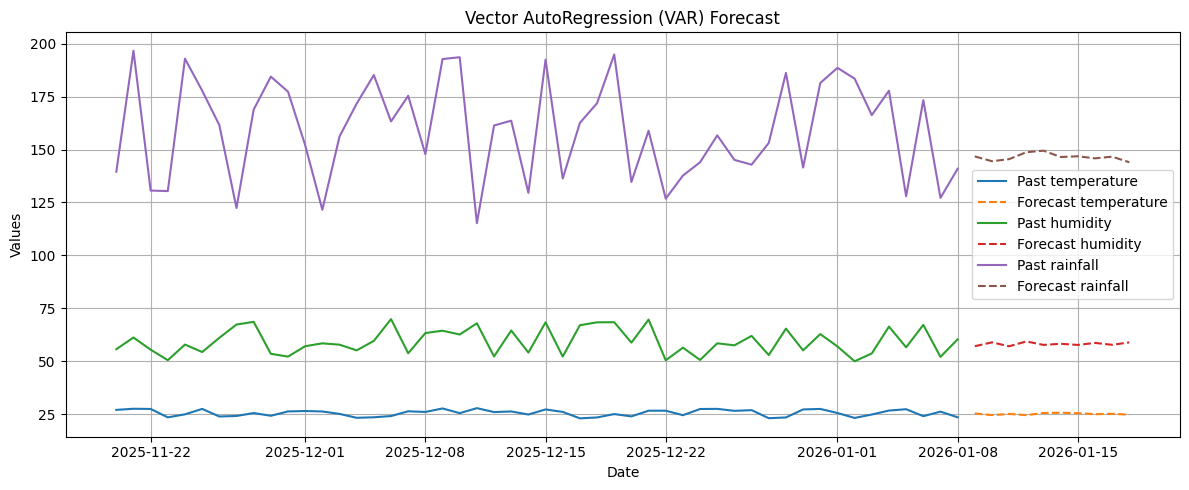

In [1]:
# Install necessary packages if running in Colab
# !pip install ipywidgets statsmodels --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import ipywidgets as widgets
from IPython.display import display

# Create file upload widget
upload = widgets.FileUpload(accept=".csv", multiple=False)
display(upload)

def handle_upload(change):
    if upload.value:
        # Read the uploaded CSV file
        uploaded_file = next(iter(upload.value.values()))
        df = pd.read_csv(pd.io.common.BytesIO(uploaded_file['content']))

        # Optional: set a datetime index if available, else use dummy daily dates
        df.index = pd.date_range(start="2020-01-01", periods=len(df), freq='D')

        # Select multiple numeric columns for multivariate time series
        # We'll use 'temperature', 'humidity', 'rainfall' if they exist
        columns = ['temperature', 'humidity', 'rainfall']
        selected_cols = [col for col in columns if col in df.columns]

        if len(selected_cols) < 2:
            print("Dataset must contain at least two of the following columns: temperature, humidity, rainfall")
            return

        df_selected = df[selected_cols]

        # Check for missing values
        df_selected = df_selected.fillna(method='ffill')

        # Split into train and forecast sets
        train = df_selected[:-10]
        model = VAR(train)

        # Fit model and select optimal lag
        results = model.fit(maxlags=15, ic='aic')

        # Forecast 10 steps ahead
        forecast_input = df_selected.values[-results.k_ar:]
        forecast = results.forecast(y=forecast_input, steps=10)

        forecast_df = pd.DataFrame(forecast, columns=selected_cols)
        forecast_df.index = pd.date_range(start=df_selected.index[-1] + pd.Timedelta(days=1), periods=10)

        # Plotting forecasted values
        plt.figure(figsize=(12, 5))
        for col in selected_cols:
            plt.plot(df_selected.index[-50:], df_selected[col].iloc[-50:], label=f"Past {col}")
            plt.plot(forecast_df.index, forecast_df[col], '--', label=f"Forecast {col}")

        plt.title("Vector AutoRegression (VAR) Forecast")
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Trigger upload handler
upload.observe(handle_upload, names='value')
